In [ ]:
!git clone https://github.com/yachty66/Leffa.git

In [ ]:
%cd Leffa

In [2]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 20.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 53.2 MB/s eta 0:00:00
  Preparing metadata (setup.

In [4]:
import numpy as np
from PIL import Image
from huggingface_hub import snapshot_download
from leffa.transform import LeffaTransform
from leffa.model import LeffaModel
from leffa.inference import LeffaInference
from leffa_utils.garment_agnostic_mask_predictor import AutoMasker
from leffa_utils.densepose_predictor import DensePosePredictor
from leffa_utils.utils import resize_and_center, get_agnostic_mask
from preprocess.humanparsing.run_parsing import Parsing
from preprocess.openpose.run_openpose import OpenPose
import time
import torch

class LeffaPredictor:
    def __init__(self, download_weights=True):
        # Download checkpoints if needed
        if download_weights:
            snapshot_download(
                repo_id="franciszzj/Leffa",
                local_dir="./ckpts",
                allow_patterns=[
                    "densepose/*",
                    "schp/*",
                    "humanparsing/*",
                    "openpose/*",
                    "stable-diffusion-inpainting/*",
                    "virtual_tryon.pth",
                ]
            )

        # Initialize models
        self.mask_predictor = AutoMasker(
            densepose_path="./ckpts/densepose",
            schp_path="./ckpts/schp",
        )

        self.densepose_predictor = DensePosePredictor(
            config_path="./ckpts/densepose/densepose_rcnn_R_50_FPN_s1x.yaml",
            weights_path="./ckpts/densepose/model_final_162be9.pkl",
        )

        self.parsing = Parsing(
            atr_path="./ckpts/humanparsing/parsing_atr.onnx",
            lip_path="./ckpts/humanparsing/parsing_lip.onnx",
        )

        self.openpose = OpenPose(
            body_model_path="./ckpts/openpose/body_pose_model.pth",
        )

        # Initialize virtual try-on model
        vt_model = LeffaModel(
            pretrained_model_name_or_path="./ckpts/stable-diffusion-inpainting",
            pretrained_model="./ckpts/virtual_tryon.pth",
        )
        self.vt_inference = LeffaInference(model=vt_model)
        self.vt_model_type = "viton_hd"

    def virtual_tryon(self, person_image_path, garment_image_path, garment_type="upper_body", steps=50, scale=2.5, seed=42):
        """
        Virtual try-on with padding information for precise cropping and original resolution restoration
        """
        # Load and store original size
        src_image = Image.open(person_image_path)
        original_size = src_image.size  # Store original dimensions
        ref_image = Image.open(garment_image_path)
        
        # Process at model's native resolution
        src_image, padding_info = resize_and_center(src_image, 768, 1024)
        ref_image, _ = resize_and_center(ref_image, 768, 1024)
        src_image_array = np.array(src_image)

        # Generate mask
        src_image = src_image.convert("RGB")
        if self.vt_model_type == "viton_hd":
            garment_type_hd = "upper" if garment_type in [
                "upper_body", "dresses"] else "lower"
            mask = self.mask_predictor(src_image, garment_type_hd)["mask"]
        elif self.vt_model_type == "dress_code":
            keypoints = self.openpose(src_image.resize((384, 512)))
            model_parse, _ = self.parsing(src_image.resize((384, 512)))
            mask = get_agnostic_mask(model_parse, keypoints, garment_type)
            mask = mask.resize((768, 1024))

        # Generate DensePose
        if self.vt_model_type == "viton_hd":
            src_image_seg_array = self.densepose_predictor.predict_seg(src_image_array)
            densepose = Image.fromarray(src_image_seg_array)
        elif self.vt_model_type == "dress_code":
            src_image_iuv_array = self.densepose_predictor.predict_iuv(src_image_array)
            src_image_seg_array = src_image_iuv_array[:, :, 0:1]
            src_image_seg_array = np.concatenate([src_image_seg_array] * 3, axis=-1)
            densepose = Image.fromarray(src_image_seg_array)

        # Prepare data for model
        transform = LeffaTransform()
        data = {
            "src_image": [src_image],
            "ref_image": [ref_image],
            "mask": [mask],
            "densepose": [densepose],
        }
        data = transform(data)

        # Run inference
        output = self.vt_inference(
            data,
            num_inference_steps=steps,
            guidance_scale=scale,
            seed=seed,
        )

        # Handle the output correctly using padding info and restore original size
        if isinstance(output, dict) and "generated_image" in output:
            result = np.array(output["generated_image"][0])
            # Remove padding using the exact dimensions we know
            result = result[padding_info['top']:padding_info['bottom'], 
                           padding_info['left']:padding_info['right']]
            # Convert to PIL and resize to original dimensions
            final_image = Image.fromarray(result)
            final_image = final_image.resize(original_size, Image.LANCZOS)
            return final_image
        elif isinstance(output, np.ndarray):
            # Remove padding using the exact dimensions we know
            result = output[padding_info['top']:padding_info['bottom'], 
                           padding_info['left']:padding_info['right']]
            # Convert to PIL and resize to original dimensions
            final_image = Image.fromarray(result)
            final_image = final_image.resize(original_size, Image.LANCZOS)
            return final_image
        else:
            raise TypeError(f"Unexpected output type from inference: {type(output)}")
    


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/diffusers/models/resnet.py:323: FutureWarning: `scale` is deprecated and will be removed in version 1.0.0. The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`.
  deprecate("scale", "1.0.0", deprecation_message)
/usr/local/lib/python3.10/dist-packages/diffusers/models/activations.py:116: FutureWarning: `scale` is deprecated and will be removed in version 1.0.0. The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`.
  deprecate("scale", "1.0.0", deprecation_message)
/usr/local/lib/python3.10/dist-packages/diffusers/models/downsampling.py:135: F

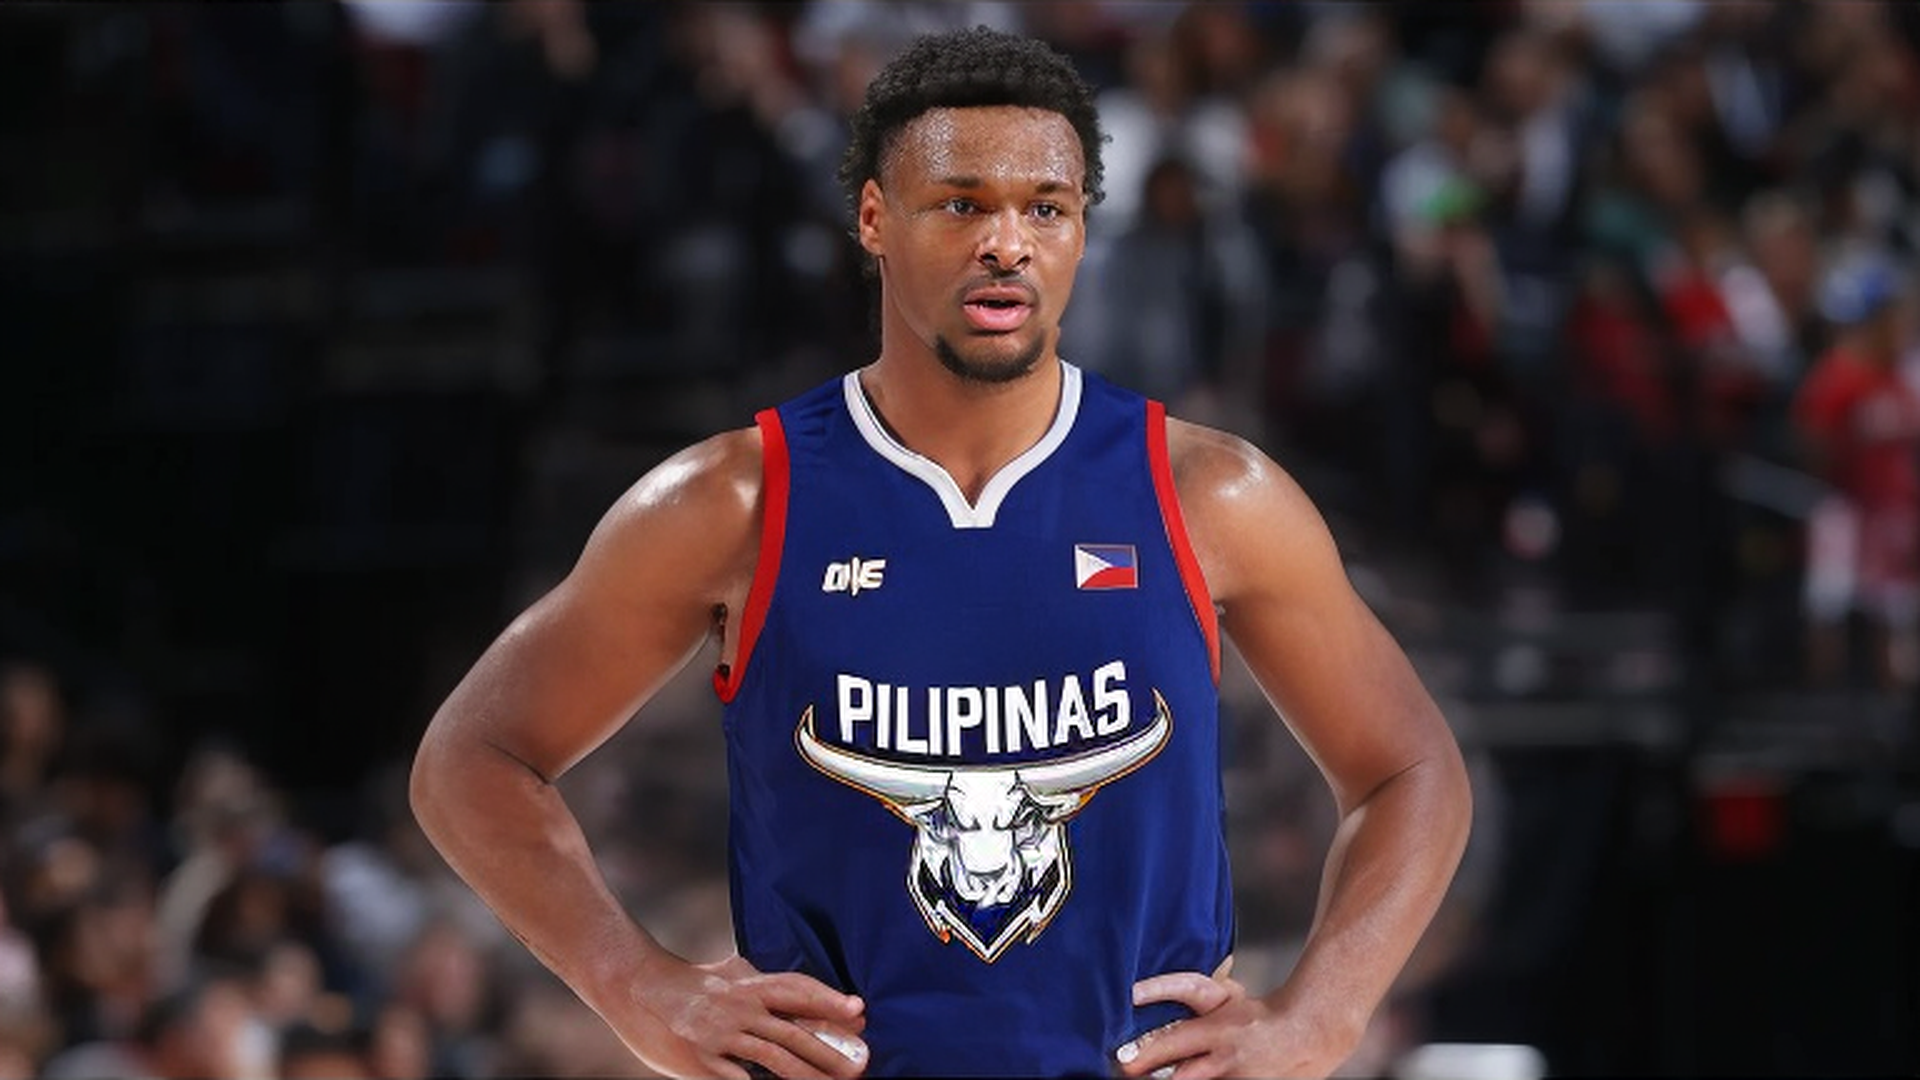

In [6]:
#! important before running this cell upload person_image_path and garment_image_path, in this case its person.jpg and jersey.jpg

# Upload your images to Colab first
# from google.colab import files
# uploaded = files.upload()  # This will prompt for person.jpg
# uploaded = files.upload()  # This will prompt for jersey.jpg

# Initialize predictor
predictor = LeffaPredictor()

# Virtual try-on
result = predictor.virtual_tryon(
    person_image_path="person.png",
    garment_image_path="jersey.png",
    garment_type="upper_body"  # or "lower_body" or "dresses"
)

# Display result
display(result)

# Save result
result.save("result.png")

# Download the result
# files.download('result.png')